In [1]:
# ============================================================
# 0. Imports
# ============================================================

# --- Standard library
from pathlib import Path

# --- Infrastructure : utils & config
from health_lifestyle_diabetes.infrastructure.utils.paths import get_repository_root
from health_lifestyle_diabetes.infrastructure.utils.config_loader import YamlConfigLoader

# --- Infrastructure : logging
from health_lifestyle_diabetes.infrastructure.logger.config import configure_logging
from health_lifestyle_diabetes.infrastructure.logger.loguru_logger import LoguruLogger

# --- Infrastructure : data
from health_lifestyle_diabetes.infrastructure.data_sources.csv_dataset_repository import (
    CSVDatasetRepository,
)

# --- Infrastructure : feature engineering & selection
from health_lifestyle_diabetes.infrastructure.feature_engineering.pipeline_feature_engineering import (
    FeatureEngineeringPipeline,
)
from health_lifestyle_diabetes.infrastructure.features_selections import (
    features_selection as fs,
)

# --- Infrastructure : dataset splitting
from health_lifestyle_diabetes.infrastructure.splitters.sklearn_splitter import (
    SklearnDatasetSplitter,
)

# --- Infrastructure : model trainers
from health_lifestyle_diabetes.infrastructure.model_trainers.catboost_trainer import (
    CatBoostTrainer,
)
from health_lifestyle_diabetes.infrastructure.model_trainers.lightgbm_trainer import (
    LightGBMTrainer,
)
from health_lifestyle_diabetes.infrastructure.model_trainers.xgboost_trainer import (
    XGBoostTrainer,
)

# --- Infrastructure : tracking & diagnostics
from health_lifestyle_diabetes.infrastructure.tracking.run_name_generator import (
    generate_run_name,
)
from health_lifestyle_diabetes.infrastructure.tracking.mlflow_tracker import (
    MLflowExperimentTracker,
)
from health_lifestyle_diabetes.infrastructure.training_diagnostics.diagnostics import (
    BoostingTrainingDiagnostics,
)

# --- Application : services & use cases
from health_lifestyle_diabetes.application.services.experiment_tracking_service import (
    ExperimentTrackingService,
)
from health_lifestyle_diabetes.application.use_cases.load_dataset_use_case import (
    LoadDatasetUseCase,
)
from health_lifestyle_diabetes.application.use_cases.split_dataset_use_case import (
    SplitDatasetUseCase,
)

from health_lifestyle_diabetes.infrastructure.training_diagnostics.diagnostics import (
    BoostingTrainingDiagnostics,
)


# ---
from health_lifestyle_diabetes.infrastructure.metrics.sklearn_metrics_adapter import SklearnMetricsAdapter
from health_lifestyle_diabetes.domain.services.evaluation_service import (
    EvaluationService,
)
from health_lifestyle_diabetes.application.use_cases.evaluate_model_uc import EvaluateModelUseCase
from health_lifestyle_diabetes.domain.entities.decision_threshold_policy import (
    DecisionThresholdPolicy,
)

from health_lifestyle_diabetes.infrastructure.metrics.sklearn_metrics_adapter import SklearnMetricsAdapter
from health_lifestyle_diabetes.domain.services.evaluation_service import EvaluationService

from health_lifestyle_diabetes.infrastructure.visualization.plotly_metrics_plotter import (
    PlotlyMetricsPlotter,
)
from health_lifestyle_diabetes.infrastructure.visualization.matplotlib_metrics_plotter import (
    MatplotlibMetricsPlotter,
)

from health_lifestyle_diabetes.infrastructure.feature_importance.boosting_feature_importance_adapter import BoostingFeatureImportanceAdapter
from health_lifestyle_diabetes.infrastructure.visualization.feature_importance_plotter import FeatureImportancePlotter

from health_lifestyle_diabetes.domain.entities.confusion_matrix_config import ConfusionMatrixConfig
from health_lifestyle_diabetes.application.services.confusion_matrix_service import ConfusionMatrixService
from health_lifestyle_diabetes.infrastructure.visualization.confusion_matrix_matplotlib_adapter import ConfusionMatrixMatplotlibAdapter

# ============================================================
# 1. Configuration & logging
# ============================================================
configure_logging(env="dev")
logger = LoguruLogger()

root = get_repository_root()
config_loader = YamlConfigLoader()

# ============================================================
# Chargement des configurations
# ============================================================
paths_cfg = config_loader.load_config(root / "configs/paths.yaml")
splitter_cfg = config_loader.load_config(root / "configs/splitter.yaml")

print("Configuration des chemins chargée (paths.yaml) :")
print(paths_cfg)
print()

print("Configuration du splitter chargée (splitter.yaml) :")
print(splitter_cfg)
print()

# ============================================================
# Résolution des chemins de données
# ============================================================
data_org_paths = get_repository_root() / Path(
    paths_cfg["data"]["input"]["raw_dataset"]
)
train_paths = get_repository_root() / Path(
    paths_cfg["data"]["input"]["train_dataset"]
)
test_paths = get_repository_root() / Path(
    paths_cfg["data"]["input"]["test_dataset"]
)

print("Chemins des datasets résolus :")
print(f"  - Raw dataset   : {data_org_paths}")
print(f"  - Train dataset : {train_paths}")
print(f"  - Test dataset  : {test_paths}")
print()

2026-01-08 12:33:49 | INFO     | config.py:67 | configure_logging() | Loguru configuré avec succès (mode: dev) | {'env': 'dev'}
Configuration des chemins chargée (paths.yaml) :
{'data': {'root': 'data/', 'input': {'raw_dataset': 'data/raw/diabetes_health_indicators.csv', 'train_dataset': 'data/input/train.csv', 'test_dataset': 'data/input/test.csv'}, 'processed': {'cleaned_dataset': 'data/processed/cleaned_diabetes.csv', 'features_dataset': 'data/processed/features_diabetes.csv'}, 'output': {'model': 'data/output/model.pkl', 'pipeline': 'data/output/pipeline.pkl'}}, 'reports': {'eda_report': 'reports/eda_reports', 'metrics_report': 'reports/metrics', 'curves_reports': 'reports/figures', 'cm_reports': 'reports/cm'}, 'logs': {'folder': 'logs', 'main_log': 'logs/app.log'}}

Configuration du splitter chargée (splitter.yaml) :
{'splitter': {'train_size': 0.85, 'target_column': 'diagnosed_diabetes', 'random_state': 42}}

Chemins des datasets résolus :
  - Raw dataset   : /Users/surelmanda/Do

In [2]:
# ============================================================
# Chargement du dataset brut
# ============================================================
logger.info("Initialisation du repository CSV")
repository = CSVDatasetRepository(
    source_path=data_org_paths,
    logger=logger,
)

logger.info("Initialisation du use case de chargement du dataset")
load_uc = LoadDatasetUseCase(
    repository=repository,
    logger=logger,
)

logger.info("Chargement du dataset brut")
dataset_org = load_uc.execute()

logger.info(
    "Dataset chargé avec succès | lignes={} | colonnes={}".format(
        dataset_org.shape[0],
        dataset_org.shape[1],
    )
)

logger.debug("Aperçu des premières lignes du dataset")
display(dataset_org.head())

# ============================================================
# Split train / test
# ============================================================
logger.info("Initialisation du splitter sklearn")
splitter = SklearnDatasetSplitter(
    train_size=splitter_cfg["splitter"]["train_size"],
    target_column=fs.TARGET_COLUMN,
    random_state=splitter_cfg["splitter"]["random_state"],
    logger=logger,
)

logger.info("Initialisation du use case de split du dataset")
split_use_case = SplitDatasetUseCase(
    splitter=splitter,
    logger=logger,
)

logger.info("Exécution du split train / test")
train_df, test_df = split_use_case.execute(dataset_org)

logger.info(
    "Split terminé | train_shape={} | test_shape={}".format(
        train_df.shape,
        test_df.shape,
    )
)

# ============================================================
# Sauvegarde des datasets
# ============================================================
save_paths = {
    "train": train_paths,
    "test": test_paths,
}

logger.info("Sauvegarde du dataset train")
train_df.to_csv(save_paths["train"], index=False)

logger.info("Sauvegarde du dataset test")
test_df.to_csv(save_paths["test"], index=False)

logger.info(
    "Sauvegarde terminée | train_path={} | test_path={}".format(
        save_paths["train"],
        save_paths["test"],
    )
)

# ============================================================
# Feature Engineering
# ============================================================
logger.info("Initialisation du pipeline de feature engineering")
fe_pipeline = FeatureEngineeringPipeline(logger=logger)

# ------------------------------------------------------------
# Train
# ------------------------------------------------------------
logger.info("Feature engineering sur le dataset train")
enriched_train_df = fe_pipeline.transform(train_df)

logger.info(
    "Feature engineering terminé (train) | colonnes_avant={} | colonnes_après={}".format(
        train_df.shape[1],
        enriched_train_df.shape[1],
    )
)
# ------------------------------------------------------------
# Test
# ------------------------------------------------------------
logger.info("Feature engineering sur le dataset test")
enriched_test_df = fe_pipeline.transform(test_df)

logger.info(
    "Feature engineering terminé (test) | colonnes_avant={} | colonnes_après={}".format(
        test_df.shape[1],
        enriched_test_df.shape[1],
    )
)

# ============================================================
# Split Train / Validation
# ============================================================
logger.info("Exécution du split enriched dataset to train / validation")

train_df, valid_df = splitter.split(enriched_train_df)

logger.info(
    "Split train / validation terminé | train_shape={} | valid_shape={}".format(
        train_df.shape,
        valid_df.shape,
    )
)

# ============================================================
# Feature Selection (IMPORTANT)
# ============================================================
logger.info(
    "Feature selection | {} features retenues".format(
        len(fs.SELECTED_FEATURES)
    )
)

# On conserve uniquement les features sélectionnées + la cible
train_df = train_df[fs.SELECTED_FEATURES + [fs.TARGET_COLUMN]]
test_df = enriched_test_df[fs.SELECTED_FEATURES + [fs.TARGET_COLUMN]]
valid_df = valid_df[fs.SELECTED_FEATURES + [fs.TARGET_COLUMN]]

logger.info("Feature selection appliquée sur train / test / validation")

# ============================================================
# Préparation X / y
# ============================================================
X_train = train_df.drop(columns=[fs.TARGET_COLUMN])
y_train = train_df[fs.TARGET_COLUMN]

X_test = test_df.drop(columns=[fs.TARGET_COLUMN])
y_test = test_df[fs.TARGET_COLUMN]

X_valid = valid_df.drop(columns=[fs.TARGET_COLUMN])
y_valid = valid_df[fs.TARGET_COLUMN]

logger.info(
    "Dimensions finales | X_train={} | X_test={} | X_valid={}".format(
        X_train.shape,
        X_test.shape,
        X_valid.shape,
    )
)

2026-01-08 12:33:49 | INFO     | 1358589329.py:4 | <module>() | Initialisation du repository CSV | {}
2026-01-08 12:33:49 | INFO     | 1358589329.py:10 | <module>() | Initialisation du use case de chargement du dataset | {}
2026-01-08 12:33:49 | INFO     | 1358589329.py:16 | <module>() | Chargement du dataset brut | {}
2026-01-08 12:33:49 | INFO     | load_dataset_use_case.py:18 | execute() | Démarrage du chargement du dataset... | {}
2026-01-08 12:33:49 | INFO     | csv_dataset_repository.py:54 | load_dataset() | Chargement du dataset depuis : /Users/surelmanda/Downloads/ml-projects/Clean-Architecture-MLops/health_lifestyle_diabetes/data/raw/diabetes_health_indicators.csv | {}
2026-01-08 12:33:49 | INFO     | csv_dataset_repository.py:61 | load_dataset() | Dataset chargé avec succès (97297 lignes, 31 colonnes). | {}
2026-01-08 12:33:49 | INFO     | load_dataset_use_case.py:20 | execute() | Dataset chargé : 97297 lignes, 31 colonnes. | {}
2026-01-08 12:33:49 | INFO     | 1358589329.py:

,Age,gender,ethnicity,education_level,income_level,employment_status,smoking_status,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,...,hdl_cholesterol,ldl_cholesterol,triglycerides,glucose_fasting,glucose_postprandial,insulin_level,hba1c,diabetes_risk_score,diabetes_stage,diagnosed_diabetes
0,58,Male,Asian,Highschool,Lower-Middle,Employed,Never,0,215,5.7,...,41,160,145,136,236,6.36,8.18,29.6,Type 2,1
1,52,Female,White,Highschool,Middle,Employed,Former,1,143,6.7,...,55,50,30,93,150,2.00,5.63,23.0,No Diabetes,0
2,60,Male,Hispanic,Highschool,Middle,Unemployed,Never,1,57,6.4,...,66,99,36,118,195,5.07,7.51,44.7,Type 2,1
3,74,Female,Black,Highschool,Low,Retired,Never,0,49,3.4,...,50,79,140,139,253,5.28,9.03,38.2,Type 2,1
4,46,Male,White,Graduate,Middle,Retired,Never,1,109,7.2,...,52,125,160,137,184,12.74,7.20,23.5,Type 2,1


2026-01-08 12:33:49 | INFO     | 1358589329.py:32 | <module>() | Initialisation du splitter sklearn | {}
2026-01-08 12:33:49 | DEBUG    | sklearn_splitter.py:37 | __init__() | SklearnDatasetSplitter initialized | {}
2026-01-08 12:33:49 | INFO     | 1358589329.py:40 | <module>() | Initialisation du use case de split du dataset | {}
2026-01-08 12:33:49 | INFO     | 1358589329.py:46 | <module>() | Exécution du split train / test | {}
2026-01-08 12:33:49 | INFO     | split_dataset_use_case.py:41 | execute() | Démarrage du split dataset... | {}
2026-01-08 12:33:49 | INFO     | sklearn_splitter.py:42 | split() | Starting dataset split | {}
2026-01-08 12:33:49 | INFO     | sklearn_splitter.py:57 | split() | Split done | train=(82702, 31) | test=(14595, 31) | {}
2026-01-08 12:33:49 | INFO     | split_dataset_use_case.py:45 | execute() | Split terminé : train=(82702, 31), test=(14595, 31) | {}
2026-01-08 12:33:49 | INFO     | split_dataset_use_case.py:48 | execute() | Sauvegarde des datasets sp

In [3]:
# ============================================================
# Étape 0 — Initialisation de l’expérience MLflow
# ============================================================
logger.info("Initialisation du tracking MLflow")

tracker = MLflowExperimentTracker(logger)
tracking_service = ExperimentTrackingService(
    tracker=tracker,
    logger=logger,
)

EXPERIMENT_NAME = "health_lifestyle_diabetes"
RUN_NAME = generate_run_name(prefix="CATB")
MODEL_NAME = "CatBoostClassifier"

logger.info(
    "Démarrage de l'expérience | experiment_name={} | run_name={}".format(
        EXPERIMENT_NAME,
        RUN_NAME,
    )
)

tracking_service.start_experiment(
    experiment_name=EXPERIMENT_NAME,
    run_name=RUN_NAME,
)

2026-01-08 12:33:53 | INFO     | 1639192692.py:4 | <module>() | Initialisation du tracking MLflow | {}
2026-01-08 12:33:53 | DEBUG    | mlflow_setup.py:36 | __init__() | Tracking URI : sqlite://///Users/surelmanda/Downloads/ml-projects/mlflow_central/db/mlruns.db | {}
2026-01-08 12:33:53 | DEBUG    | mlflow_setup.py:37 | __init__() | Artifact URI : /Users/surelmanda/Downloads/ml-projects/mlflow_central/mlflow_artifacts | {}


2026/01/08 12:33:53 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/01/08 12:33:53 INFO mlflow.store.db.utils: Updating database tables
2026/01/08 12:33:53 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/08 12:33:53 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/01/08 12:33:53 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/08 12:33:53 INFO alembic.runtime.migration: Will assume non-transactional DDL.


2026-01-08 12:33:53 | INFO     | mlflow_setup.py:53 | configure() | MLflow configuré avec succès. | {}
2026-01-08 12:33:53 | INFO     | mlflow_tracker.py:25 | __init__() | MLflowExperimentTracker prêt. | {}
2026-01-08 12:33:53 | INFO     | experiment_tracking_service.py:23 | __init__() | ExperimentTrackingService initialisé. | {}
2026-01-08 12:33:53 | INFO     | 1639192692.py:16 | <module>() | Démarrage de l'expérience | experiment_name=health_lifestyle_diabetes | run_name=CATB_2026-01-08_12h33m53s | {}
2026-01-08 12:33:53 | INFO     | experiment_tracking_service.py:30 | start_experiment() | Initialisation de l'expérience 'health_lifestyle_diabetes' (run='CATB_2026-01-08_12h33m53s') | {}
2026-01-08 12:33:53 | INFO     | mlflow_tracker.py:56 | setup_experiment() | Expérience active : health_lifestyle_diabetes | {}
2026-01-08 12:33:53 | INFO     | mlflow_tracker.py:70 | start_run() | Run démarrée : CATB_2026-01-08_12h33m53s | {}


In [16]:
# ============================================================
# Étape 1 — Entraînement CatBoost
# ============================================================
logger.info("Configuration des hyperparamètres CatBoost")

catboost_params = {
    "iterations": 200,
    "learning_rate": 0.5,
    "depth": 6,
    "loss_function": "Logloss",
    "eval_metric": "Logloss",
    "verbose": 100,
}

logger.info("Initialisation du trainer CatBoost")
trainer = CatBoostTrainer(
    params=catboost_params,
    logger=logger,
)

logger.info("Démarrage de l'entraînement CatBoost")
model = trainer.train(
    X_train=X_train,
    y_train=y_train,
    X_valid=X_valid,
    y_valid=y_valid,
)

logger.info("Entraînement CatBoost terminé")

2026-01-08 02:36:51 | INFO     | 4132546091.py:4 | <module>() | Configuration des hyperparamètres CatBoost | {}
2026-01-08 02:36:51 | INFO     | 4132546091.py:15 | <module>() | Initialisation du trainer CatBoost | {}
2026-01-08 02:36:51 | INFO     | catboost_trainer.py:38 | __init__() | CatBoostTrainer initialisé avec les paramètres fournis. | {}
2026-01-08 02:36:51 | INFO     | 4132546091.py:21 | <module>() | Démarrage de l'entraînement CatBoost | {}
2026-01-08 02:36:51 | INFO     | catboost_trainer.py:111 | train() | Entraînement CatBoost | train_shape=(70296, 5) | valid_shape=(12406, 5) | {}
2026-01-08 02:36:51 | INFO     | catboost_trainer.py:127 | train() | Détection automatique des variables catégorielles : ['glucose_status'] | {}
2026-01-08 02:36:51 | INFO     | catboost_trainer.py:137 | train() | Démarrage de l'entraînement CatBoost. | {}
0:	learn: 0.2499155	test: 0.2518922	best: 0.2518922 (0)	total: 29.7ms	remaining: 5.92s
100:	learn: 0.1988921	test: 0.2212484	best: 0.2161532 

2026-01-08 02:36:58 | INFO     | 1138373014.py:4 | <module>() | Lancement des diagnostics d'entraînement | {}


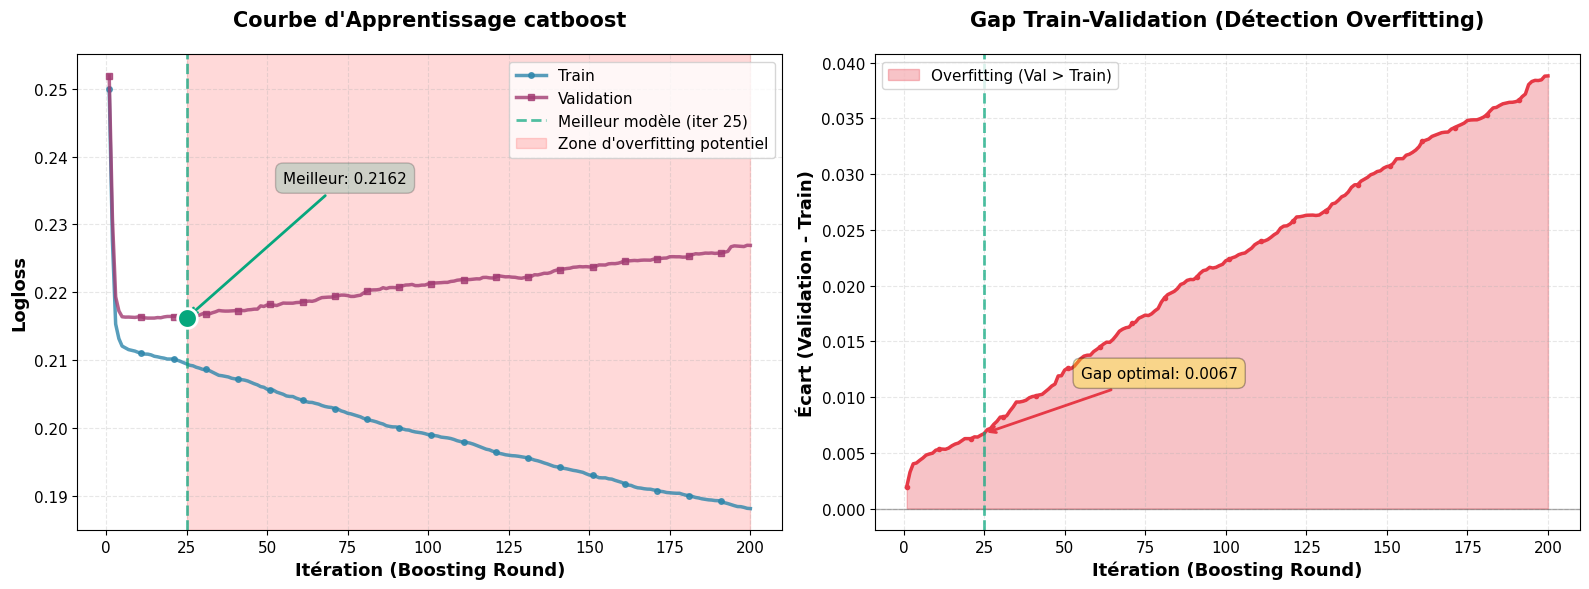

2026-01-08 02:36:59 | INFO     | 1138373014.py:17 | <module>() | Diagnostics d'entraînement générés | {}


In [17]:
# ============================================================
# Étape 2 — Diagnostics d'entraînement
# ============================================================
logger.info("Lancement des diagnostics d'entraînement")

diagnostics = BoostingTrainingDiagnostics(
    model=model,
    model_name="catboost",
    run_name=RUN_NAME,
)

diagnostics.run(
    backend="matplotlib",
    save_figure=True,
)

logger.info("Diagnostics d'entraînement générés")

2026-01-08 02:19:55 | INFO     | 3557488209.py:4 | <module>() | Extraction des feature importances | {}
2026-01-08 02:19:55 | INFO     | 3557488209.py:9 | <module>() | Feature importances extraites | nombre_features=5 | {}
2026-01-08 02:19:55 | INFO     | 3557488209.py:15 | <module>() | Génération du plot des feature importances | {}
2026-01-08 02:19:55 | INFO     | feature_importance_plotter.py:33 | plot() | Génération du barplot des feature importances | {}
2026-01-08 02:19:55 | INFO     | feature_importance_plotter.py:54 | plot() | Figure sauvegardée ➜ /Users/surelmanda/Downloads/ml-projects/Clean-Architecture-MLops/health_lifestyle_diabetes/reports/figures/feature_importances_catboost.png | {}


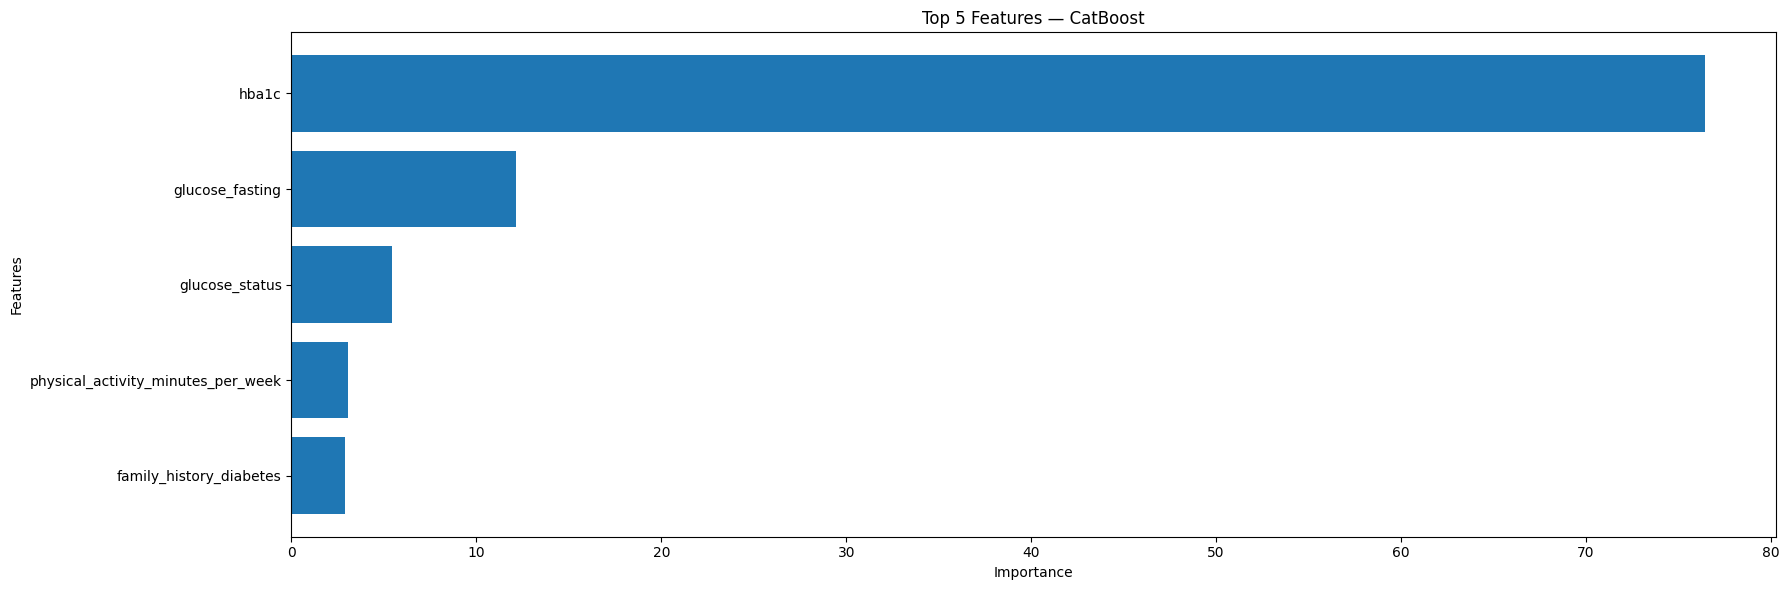

2026-01-08 02:19:55 | INFO     | feature_importance_plotter.py:57 | plot() | Affichage du barplot des feature importances terminé | {}


In [6]:
# ============================================================
# Étape 3 — Feature importance
# ============================================================
logger.info("Extraction des feature importances")

extractor = BoostingFeatureImportanceAdapter()
importances = extractor.get_feature_importances(model)

logger.info(
    "Feature importances extraites | nombre_features={}".format(
        len(importances)
    )
)

logger.info("Génération du plot des feature importances")
plotter = FeatureImportancePlotter(logger)
plotter.plot(
    importances=importances,
    top_n=5,
    model_name="CatBoost",
    save_plot=True,
)

In [15]:
# ============================================================
# Étape 4 — Évaluation du modèle
# ============================================================
logger.info("Prédiction des probabilités sur le jeu de validation")

y_proba = model.predict_proba(X_valid)[:, 1]
y_true = y_valid

logger.info("Initialisation des composants d'évaluation")

metrics_adapter = SklearnMetricsAdapter()
threshold_policy = DecisionThresholdPolicy.balanced_policy()

logger.info(
    "Politique de seuil appliquée | threshold_policy={}".format(
        threshold_policy
    )
)

type_plot = "Plotly"
if type_plot == "Matplotlib":
    metrics_plotter = MatplotlibMetricsPlotter(logger=logger)
    plot_title="Métriques principales (Matplotlib)"
else:
    metrics_plotter = PlotlyMetricsPlotter(logger=logger,width= 1340, height= 500)
    plot_title="Métriques principales (Plotly)"

evaluator = EvaluationService(
    metrics_adapter=metrics_adapter,
    decision_threshold=threshold_policy,
    plotter=metrics_plotter,
)

evaluate_uc = EvaluateModelUseCase(
    evaluation_service=evaluator,
    logger=logger,
)

logger.info("Exécution de l'évaluation du modèle")

evaluate_uc.execute(
    y_true=y_true,
    y_proba=y_proba,
    plot_metrics=True,
    selected_metrics=["accuracy", "precision", "recall", "f1", "auc_roc"],
    plot_title=plot_title,
)


# Log evaluation metrics
#tracking_service.log_evaluation(main)

# Logs Parametres sur mlflows
#tracking.log_training_context(
#    model_name=MODEL_NAME,
#    params=catboost_params
#)

# Logs les metrics sur mlflows
#tracking.log_evaluation(metrics)

2026-01-08 02:35:51 | INFO     | 2908767627.py:4 | <module>() | Prédiction des probabilités sur le jeu de validation | {}
2026-01-08 02:35:51 | INFO     | 2908767627.py:9 | <module>() | Initialisation des composants d'évaluation | {}
2026-01-08 02:35:51 | INFO     | 2908767627.py:14 | <module>() | Politique de seuil appliquée | threshold_policy=DecisionThresholdPolicy(threshold=0.5) | {}
2026-01-08 02:35:51 | INFO     | 2908767627.py:39 | <module>() | Exécution de l'évaluation du modèle | {}
2026-01-08 02:35:51 | INFO     | evaluate_model_uc.py:72 | execute() | Démarrage de l'évaluation du modèle. | {}
2026-01-08 02:35:51 | DEBUG    | evaluate_model_uc.py:77 | execute() | Input received | n_samples=12406 | plot_metrics=True | selected_metrics=['accuracy', 'precision', 'recall', 'f1', 'auc_roc'] | {}
2026-01-08 02:35:51 | INFO     | evaluate_model_uc.py:87 | execute() | Lancement du service d'évaluation métier. | {}
2026-01-08 02:35:51 | INFO     | evaluate_model_uc.py:93 | execute() | 

2026-01-08 02:35:51 | INFO     | evaluate_model_uc.py:121 | execute() | Visualisation des métriques terminée. | {}
2026-01-08 02:35:51 | INFO     | evaluate_model_uc.py:127 | execute() | Use case EvaluateModelUseCase terminé avec succès. | {}


EvaluationResults(auc_roc=0.9395, auc_pr=0.9703, accuracy=0.9195, precision=1.0, recall=0.8658, f1=0.9281, false_positive_rate=None, false_negative_rate=None, kappa=0.8377, mcc=0.8489, extra_metrics={'accuracy': 0.9195, 'precision': 1.0, 'recall': 0.8658, 'f1': 0.9281, 'auc_roc': 0.9395, 'auc_pr': 0.9703, 'false_positive_rate': 0.0, 'false_negative_rate': 0.1342, 'kappa': 0.8377, 'mcc': 0.8489})

2026-01-08 01:47:07 | INFO     | 1419569237.py:4 | <module>() | Initialisation du service de matrice de confusion | {}
2026-01-08 01:47:07 | INFO     | 1419569237.py:14 | <module>() | Génération des matrices de confusion | normalization=pred | {}
2026-01-08 01:47:07 | INFO     | confusion_matrix_service.py:33 | run() | Exécution CM avec normalisation='pred' | {}
2026-01-08 01:47:07 | INFO     | confusion_matrix_matplotlib_adapter.py:57 | plot() | [ADAPTER] CM | normalization=pred | {}


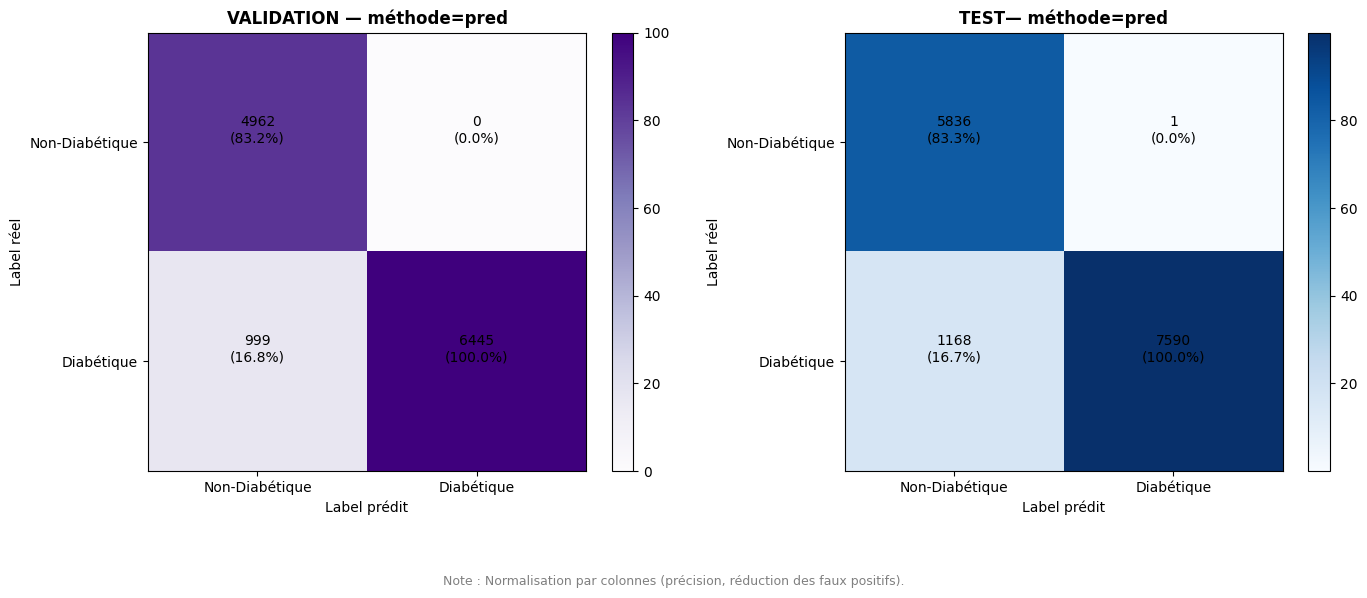

2026-01-08 01:47:07 | INFO     | confusion_matrix_matplotlib_adapter.py:70 | plot() | [ADAPTER] Sauvegardé -> /Users/surelmanda/Downloads/ml-projects/Clean-Architecture-MLops/health_lifestyle_diabetes/reports/cm/CATB_2026-01-08_01h46m57s_cm_pred.png | {}
2026-01-08 01:47:07 | INFO     | confusion_matrix_service.py:46 | run() | Matrice(s) de confusion générée(s). | {}


In [20]:
# ============================================================
# Étape 5 — Matrices de confusion
# ============================================================
logger.info("Initialisation du service de matrice de confusion")

confusion_service = ConfusionMatrixService(
    plotter=ConfusionMatrixMatplotlibAdapter(logger),
    logger=logger,
)

normalization = "pred"  # recommandé pour contexte médical
config = ConfusionMatrixConfig(normalization=normalization)

logger.info(
    "Génération des matrices de confusion | normalization={}".format(
        normalization
    )
)

confusion_service.run(
    model=model,
    X_test=X_test,
    y_test=y_test,
    X_valid=X_valid,
    y_valid=y_valid,
    config=config,
    run_name=RUN_NAME,
    save=True,
)

In [21]:
# ============================================================
# Étape 6 — Clôture de l'expérience
# ============================================================
logger.info("Clôture de l'expérience MLflow")
tracking_service.close()

2026-01-08 01:47:07 | INFO     | 1581524631.py:4 | <module>() | Clôture de l'expérience MLflow | {}
2026-01-08 01:47:07 | INFO     | experiment_tracking_service.py:61 | close() | Fermeture de l'expérience. | {}
2026-01-08 01:47:07 | INFO     | mlflow_tracker.py:76 | end_run() | Fermeture de la run : 9e3ba3c6320646158d6da83533db6bc3 | {}


# Calibration curve of a Catboost model (Sigmoid calibration).


In [23]:
print("\nEntraînement du modèle CatBoost calibré en interne...\n")
# ============================================================
# 1.) Définition du modèle + log des paramètres
# ============================================================
# =========================
# Paramètres CatBoost
# =========================
catboost_params = {
    # Calibration naturelle via optimisation logloss
    "loss_function":"Logloss",
    "eval_metric":"Logloss",    #"AUC"

    # Paramétrage pour probas stables
    "learning_rate":0.03,
    "depth":6,
    "l2_leaf_reg":5,         
    "border_count":128,       # Finesse des seuils -> proba moins extrêmes
    "random_seed":42,

    # Anti-surapprentissage -> proba + fiables
    "bootstrap_type":"Bayesian",
    "bagging_temperature":0.5,
    "rsm":0.8,

    # Données déséquilibrées ? -> meilleure calibration native
    "auto_class_weights":"Balanced",   # <--- très important

    # Optimisation
    "iterations": 1000,
    "early_stopping_rounds":50,
    "verbose":100
}
# =========================
# Entraînement
# =========================
trainer = CatBoostTrainer(params=catboost_params,logger=logger)
calibrated_catboost_model = trainer.train(
    X_train=X_train,
    y_train=y_train,
    X_valid=X_valid,
    y_valid=y_valid,
)

print("Modèle entraîné :", calibrated_catboost_model)

print("\n" + "="*80 + "\n")
print("\n" + "="*80 + "\n")

print("\nEntraînement du modèle CatBoost non calibré...\n")
# =========================
# Paramètres CatBoost
# =========================
catboost_params = {
    "iterations": 1000,
    "learning_rate": 0.05,
    "depth": 6,
    "loss_function": "Logloss",
    "eval_metric": "Logloss",  #"AUC"
    "verbose": 100,   # ← test du verbose
}
# Tracking des paramètres sur l'expérience mlflow
tracking_service.log_training_context(model_name=MODEL_NAME, params=catboost_params)
# =========================
# Entraînement
# =========================
trainer = CatBoostTrainer(params=catboost_params,logger=logger)
no_calibrated_catboost_model = trainer.train(
    X_train=X_train,
    y_train=y_train,
    X_valid=X_valid,
    y_valid=y_valid,
)

print("Modèle entraîné :", no_calibrated_catboost_model)


Entraînement du modèle CatBoost calibré en interne...

2026-01-08 01:51:44 | INFO     | catboost_trainer.py:38 | __init__() | CatBoostTrainer initialisé avec les paramètres fournis. | {}
2026-01-08 01:51:44 | INFO     | catboost_trainer.py:111 | train() | Entraînement CatBoost | train_shape=(70296, 5) | valid_shape=(12406, 5) | {}
2026-01-08 01:51:44 | INFO     | catboost_trainer.py:127 | train() | Détection automatique des variables catégorielles : ['glucose_status'] | {}
2026-01-08 01:51:44 | INFO     | catboost_trainer.py:137 | train() | Démarrage de l'entraînement CatBoost. | {}
0:	learn: 0.6350543	test: 0.6353250	best: 0.6353250 (0)	total: 29.3ms	remaining: 29.3s
100:	learn: 0.2056851	test: 0.2098220	best: 0.2098220 (100)	total: 1.86s	remaining: 16.6s
200:	learn: 0.2047909	test: 0.2095030	best: 0.2094846 (170)	total: 3.56s	remaining: 14.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2094808012
bestIteration = 209

Shrink model to first 210 iterations.
2026

2026-01-08 01:52:06 | INFO     | calibration_plot_service.py:25 | generate() | Début génération plots calibration... | {}
2026-01-08 01:52:06 | INFO     | calibration_matplotlib_adapter.py:66 | plot_calibration() | Plot calibration pour le modèle 'CatBoost' | {}
2026-01-08 01:52:07 | INFO     | calibration_matplotlib_adapter.py:115 | plot_calibration() | Calibration plot sauvegardé : /Users/surelmanda/Downloads/ml-projects/Clean-Architecture-MLops/health_lifestyle_diabetes/reports/figures/CatBoost_calibration_plot.png | {}


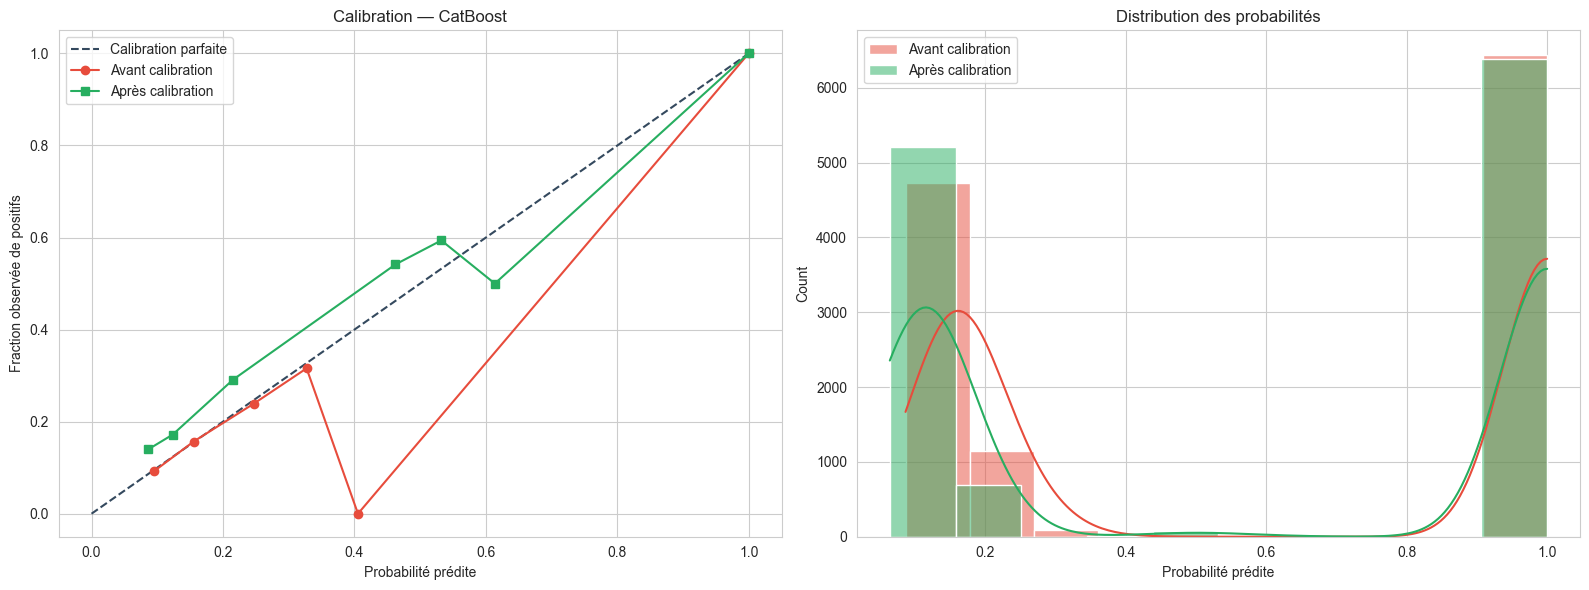

2026-01-08 01:52:07 | INFO     | calibration_matplotlib_adapter.py:118 | plot_calibration() | Plot de calibration terminé. | {}
2026-01-08 01:52:07 | INFO     | calibration_plot_service.py:34 | generate() | Plots calibration générés avec succès. | {}


In [24]:
# -- Plot Calibration
from health_lifestyle_diabetes.infrastructure.visualization.calibration_matplotlib_adapter import (
    MatplotlibCalibrationPlotAdapter,
)
from health_lifestyle_diabetes.application.services.calibration_plot_service import (
    CalibrationPlotService,
)


# =====================================
#  3. PLOT AVANT vs APRES CALIBRATION
# =====================================
plot_adapter = MatplotlibCalibrationPlotAdapter(logger=LoguruLogger())
plot_service = CalibrationPlotService(plotter=plot_adapter, logger=LoguruLogger())

# Probabilités AVANT / APRES calibration
proba_before = no_calibrated_catboost_model.predict_proba(X_valid)[:, 1]
proba_after  = calibrated_catboost_model.predict_proba(X_valid)[:, 1]

plot_service.generate(
    y_true=y_valid,
    y_proba_before=proba_before,
    y_proba_after=proba_after,
    model_name="CatBoost",
    bins=10,
    save=True
)